In [27]:
from google.colab import drive
drive.mount('/content/drive')
from collections import Counter
%cd /content/drive/MyDrive/Baseline_MUSS_corrupt/muss
!pip install -e . 
# !pip install -U spacy ==2.0.0
!python -m spacy download en_core_web_md
# from matplot.pyplot
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Baseline_MUSS_corrupt/muss
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/Baseline_MUSS_corrupt/muss
  Cloning https://github.com/feralvam/easse.git to /tmp/pip-install-yen635ic/easse_772cbb11579f491e8515db610cbefe23
  Running command git clone -q https://github.com/feralvam/easse.git /tmp/pip-install-yen635ic/easse_772cbb11579f491e8515db610cbefe23
  Cloning https://github.com/kpu/kenlm.git to /tmp/pip-install-yen635ic/kenlm_6170c154dbaa4b67b83240abc99e741b
  Running command git clone -q https://github.com/kpu/kenlm.git /tmp/pip-install-yen635ic/kenlm_6170c154dbaa4b67b83240abc99e741b
  Cloning https://github.com/facebookresearch/text-simplification-evaluation.git (to revision main) to /tmp/pip-install-yen635ic/tseval_f3bea302cc7e423cb3bfec81de14b

In [29]:
from collections import Counter
import matplotlib.pyplot as plt
from muss.mining.training import get_bart_kwargs, get_score_rows
from muss.resources.prepare import prepare_wikilarge_detokenized, prepare_asset
from muss.resources.datasets import create_smaller_dataset

from muss.fairseq.main import fairseq_train_and_evaluate_with_parametrization
from muss.mining.training import get_score_rows #get_bart_kwargs

#########################
import re
import shutil
import os 

from cachier import cachier
from easse.cli import evaluate_system_output
from easse.utils.constants import TEST_SETS_PATHS
import torch
from tqdm import tqdm

from muss.resources.paths import get_data_filepath, MODELS_DIR, get_dataset_dir
from muss.utils.helpers import add_dicts, args_str_to_dict
from muss.utils.resources import download_and_extract
from muss.preprocessors import GPT2BPEPreprocessor
from muss.preprocessing import apply_line_function_to_file
from muss.fairseq.main import get_language_from_dataset
from muss.text import truncate

from muss.simplify import simplify_sentences
from muss.utils.helpers import *

from muss.simplifiers import get_fairseq_simplifier, get_preprocessed_simplifier
from muss.preprocessors import get_preprocessors, get_preprocessor_by_name

In [13]:

# This dataset should exist in resources/datasets/ and contain the following files:
# train.complex, train.simple, valid.complex, valid.simple, test.complex, test.simple
def get_evaluate_kwargs(language, phase='valid'):
    return {
        ('en', 'valid'): {'test_set': 'asset_valid'},
        ('en', 'test'): {'test_set': 'asset_test'},
        ('fr', 'valid'): {
            'test_set': 'custom',
            'orig_sents_path': get_data_filepath('alector', 'valid', 'complex'),
            'refs_sents_paths': [get_data_filepath('alector', 'valid', 'simple')],
        },
        ('fr', 'test'): {
            'test_set': 'custom',
            'orig_sents_path': get_data_filepath('alector', 'test', 'complex'),
            'refs_sents_paths': [get_data_filepath('alector', 'test', 'simple')],
        },
        ('es', 'valid'): {
            'test_set': 'custom',
            'orig_sents_path': get_data_filepath('simplext_corpus', 'valid', 'complex'),
            'refs_sents_paths': [get_data_filepath('simplext_corpus', 'valid', 'simple')],
        },
        ('es', 'test'): {
            'test_set': 'custom',
            'orig_sents_path': get_data_filepath('simplext_corpus', 'test', 'complex'),
            'refs_sents_paths': [get_data_filepath('simplext_corpus', 'test', 'simple')],
        },
    }[(language, phase)]

evaluate_kwargs=get_evaluate_kwargs('en')


def get_predict_files(language):
    return {
        'en': [get_data_filepath('asset', 'valid', 'complex'), get_data_filepath('asset', 'test', 'complex')],
        'fr': [get_data_filepath('alector', 'valid', 'complex'), get_data_filepath('alector', 'test', 'complex')],
        'es': [
            get_data_filepath('simplext_corpus', 'valid', 'complex'),
            get_data_filepath('simplext_corpus', 'test', 'complex'),
        ],
    }[language]

def get_access_preprocessors_kwargs(language, use_short_name=False):
    return {
        'LengthRatioPreprocessor': {'target_ratio': 0.8, 'use_short_name': use_short_name},
        'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8, 'use_short_name': use_short_name},
        'WordRankRatioPreprocessor': {'target_ratio': 0.8, 'language': language, 'use_short_name': use_short_name},
        'DependencyTreeDepthRatioPreprocessor': {
            'target_ratio': 0.8,
            'language': language,
            'use_short_name': use_short_name,
        },
    }

def get_bart_kwargs(dataset, language, use_access, use_short_name=False, bart_model='bart.large'):
    assert language == 'en'

    bart_path = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/models/bart_mined/model.pt'
    arch = {
        'bart.base': 'bart_base',
        'bart.large': 'bart_large',
        'bart.large.cnn': 'bart_large',
    }[bart_model]
    kwargs = {
        'dataset': dataset,
        'metrics_coefs': [0, 1, 0],
        'parametrization_budget': 128,
        'predict_files': get_predict_files(language), # used in fairseq_evaluate_and_save
        'preprocessors_kwargs': {
            'GPT2BPEPreprocessor': {},
        },
        'preprocess_kwargs': {'dict_path': GPT2BPEPreprocessor().dict_path},
        'train_kwargs': {
            'ngpus': 1,
            'arch': arch,
            'restore_file': bart_path,
            'max_tokens': 4096,
            'lr': 8e-05,
            'warmup_updates': 500, #500
            'truncate_source': True,
            'layernorm_embedding': True,
            'share_all_embeddings': True,
            'share_decoder_input_output_embed': True,
            'reset_optimizer': True,
            'reset_dataloader': True,
            'reset_meters': True,
            'required_batch_size_multiple': 1,
            'criterion': 'label_smoothed_cross_entropy',
            'label_smoothing': 0.1,
            'dropout': 0.1,
            'attention_dropout': 0.1,
            'weight_decay': 0.01,
            'optimizer': 'adam',
            'adam_betas': '(0.9, 0.999)',
            'adam_eps': 1e-08,
            'clip_norm': 0.1,
            'lr_scheduler': 'polynomial_decay',
            'max_update': 10000, # 20000
            'skip_invalid_size_inputs_valid_test': True,
            'find_unused_parameters': True,
        },
        'evaluate_kwargs': get_evaluate_kwargs(language),
    }
    if use_access:
        kwargs['preprocessors_kwargs'] = add_dicts(
            get_access_preprocessors_kwargs(language, use_short_name=use_short_name), kwargs['preprocessors_kwargs']
        )
    return kwargs

### Compute hardword word retention rate 
def find_occurence(NE,simple_sentence):
  NE_simp = [i.lower() for i in NE['NE_simple']]
  NE_diff = [i.lower() for i in NE['NE_difficult']]
  simple_sentence = simple_sentence.lower()
  intersect_words = []

  count_simple = 0
  count_difficult = 0
  # print(NE_diff)
  # print(NE)
  if NE_simp[0] != '' or NE_diff:
    # print(NE_simp[0] == '')
  # print(sentence,test_complex_NER_spacy[index])
    if NE_simp[0] != '':
      for text in NE_simp:
        if text.lower() in simple_sentence:
          intersect_words.append(text)
          count_simple +=1
    else:
      count_simple = None
    
    if NE_diff:
      for text in NE_diff:
        if text.lower() in simple_sentence:
          intersect_words.append(text)
          count_difficult +=1
          # print('diff words found in sen')
    else:
      count_difficult = None

    return count_simple, count_difficult
  else:
    # print('empty NE')
    return None, None
    
    
def word_retention_rate(comp_sentence,simp_sentence):
  total_simp = 0
  total_diff = 0
  counter_simp = 0
  counter_diff = 0

  for i,sentence in enumerate(simp_sentence):
    NE_temp1 = NE_extraction(comp_sentence[i])[0]

    count_simp, count_diff = find_occurence(NE_temp1,sentence)

    if count_simp != None or count_diff != None:
      if count_simp != None:
        total_simp += len(NE_temp1['NE_simple'])
        counter_simp += count_simp
      if count_diff != None:
        total_diff += len(NE_temp1['NE_difficult'])
        counter_diff += count_diff
    else:
      pass
    # print(count_simp, count_diff)
  if total_diff != 0 and total_simp!=0:
    print('-'*50)
    print('simple_NE retention rate',counter_simp/total_simp)
    print('difficult_NE retention rate',counter_diff/total_diff)
    print(total_diff)
    print('total_NE retention rate', (counter_simp+counter_diff)/(total_simp+total_diff))
    print('-'*50)
    return counter_simp/total_simp,counter_diff/total_diff, (counter_simp+counter_diff)/(total_simp+total_diff)

  else:
    if total_simp != 0:
      print('-'*50)
      print('simple_NE retention rate',counter_simp/total_simp)
      print('-'*50)
      return counter_simp/total_simp
    if total_diff != 0:
      print('-'*50)
      print('difficult_NE retention rate',counter_diff/total_diff)
      # print('total_NE retention rate', (counter_simp+counter_diff)/(total_simp+total_diff))
      print('-'*50)
      # print('No stats provided for diff_NE becuase no diff NE at all')
    



def word_retention_rate_per_sentence(comp_sentence,simp_sentence):
  total_simp_list = []
  total_diff_list = []
  total_list = []
  # counter_simp_list = []
  # counter_diff_list = []

  for i,sentence in enumerate(simp_sentence):
    total_simp = 0
    total_diff = 0
    counter_simp = 0
    counter_diff = 0

    NE_temp1 = NE_extraction(comp_sentence[i])[0]

    count_simp, count_diff = find_occurence(NE_temp1,sentence)
    if count_simp != None or count_diff != None:
      if count_simp != None:
        total_simp += len(NE_temp1['NE_simple'])
        counter_simp += count_simp
      if count_diff != None:
        total_diff += len(NE_temp1['NE_difficult'])
        counter_diff += count_diff
    else:
      pass
    # print(count_simp, count_diff)
    if total_diff != 0:
      # print('simple_NE retention rate',counter_simp/total_simp)
      # print('difficult_NE retention rate',counter_diff/total_diff)
      # print('total_NE retention rate', (counter_simp+counter_diff)/(total_simp+total_diff))
      total_diff_list.append(counter_diff/total_diff)
    if total_simp != 0:
      total_simp_list.append(counter_simp/total_simp)
    if total_simp != 0 or total_diff != 0:
      total_list.append((counter_simp+counter_diff)/(total_simp+total_diff))
      # if type(counter_diff/total_diff) == float:
      #   total_diff_list.append(counter_diff/total_diff)
      # else:
      #   print(counter_diff,total_diff)
      #   total_diff_list.append(counter_diff/total_diff)

      # return counter_simp/total_simp,counter_diff/total_diff, (counter_simp+counter_diff)/(total_simp+total_diff)
    # else:
    #   total_simp_list.append(counter_simp/total_simp)
    #   total_list.append((counter_simp+counter_diff)/(total_simp+total_diff))
  print('-'*50)
  print('Word retention rate per sentence')
  print('simple_NE retention rate',np.average(total_simp_list))
  print('difficult_NE retention rate',np.average(total_diff_list))
  # print(total_diff_list)
  print('total_NE retention rate',np.average(total_list))
  print('-'*50)


def generate_output(chosen_id_list,data_dir_list,data_list,model_dir_dict,sample=False,add_to_dir_name=None,muss_output=False,NE_output=False,CERF_output=False,NE_CERF_output=False,hypothesis_num=None,beam=None,sampling=False):

  # store created dir
  created_dir = []
  output_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/'
  for index in chosen_id_list:
    
    # get model unique local id
    exp_dir = model_dir_dict[index]['exp_dir']
    print('| model_name is',model_dir_dict[index]['model_name'])
    print('| exp_dir is',exp_dir)

    model_name = 'model_'+ str(index) + '_'+ exp_dir.split('/')[-2]

    os.makedirs(output_dir+model_name, exist_ok=True)
    print('| output_dir',output_dir)
    language = 'en'

    # get recommended_preprocessors_kwargs
    if 'recommended_preprocessors_kwargs' in model_dir_dict[index].keys() :
      preprocessors_kwargs = model_dir_dict[index]['recommended_preprocessors_kwargs']
      print('| use provided kwargs')
    else:
      # use muss_mined_wiki preprocessors
      preprocessors_kwargs = {
            'LengthRatioPreprocessor': {'target_ratio': 0.9, 'use_short_name': False},
            'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.65, 'use_short_name': False},
            'WordRankRatioPreprocessor': {'target_ratio': 0.75, 'language': language, 'use_short_name': False},
            'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.4, 'language': language, 'use_short_name': False},
        }
      preprocessors_kwargs['GPT2BPEPreprocessor'] = {}

    print('| use preprocessors_kwargs',preprocessors_kwargs)
    preprocessors = get_preprocessors(preprocessors_kwargs)

    if hypothesis_num == None:
      hypothesis_num = 1
    if beam == None:
      beam=5

    generate_kwargs = {'hypothesis_num':hypothesis_num,
                       'beam':beam,
                       'sampling':sampling}

    simplifier = get_fairseq_simplifier(exp_dir, **generate_kwargs)
    simplifier = get_preprocessed_simplifier(simplifier, preprocessors=preprocessors)

    #########################################
    # simplify sample sentences 

    ############################## I need to change the directory 
    if sample:
      if muss_output:
        complex_file_dir = '/content/drive/MyDrive/muss/scripts/contract_no_token.en'
      elif NE_output:
        complex_file_dir = '/content/drive/MyDrive/muss/scripts/contract_NE_token.en'
      elif CERF_output:
        complex_file_dir = '/content/drive/MyDrive/muss/scripts/contract_ABCD_token.en'
      elif NE_CERF_output:
        complex_file_dir = '/content/drive/MyDrive/muss/scripts/contract_NE_ABCD_token.en'

      pred_path = simplifier(complex_file_dir)

      for i in range(len(read_lines(complex_file_dir))):
        print('original:\n',read_lines(complex_file_dir)[i])
        print('simplified:\n',read_lines(pred_path)[i])
        print('----------------------------------------------------')

      return read_lines(complex_file_dir),read_lines(pred_path)
    ###########################################

    # create dir for output
    subfolders = os.listdir(output_dir + model_name)
    num_subfolder = len(subfolders)
    new_folder_dir = output_dir + model_name + '/' +str(num_subfolder).zfill(2) +'/'
    os.mkdir(new_folder_dir)
    created_dir.append(new_folder_dir)

     # simplify asset dataset
    for index, file_dir in enumerate(data_dir_list):
      
      info_file_name = new_folder_dir + 'info.txt'
      with open(info_file_name, 'w') as f:
        f.write("generate_kwargs %s\n" % generate_kwargs)
      f.close()

      filename = new_folder_dir + data_list[index]
      print('filename;', filename)
      pred_path = simplifier(file_dir)

      with open(filename, 'w') as f:
          for item in read_lines(pred_path):
              f.write("%s\n" % item)

  print('created_dir',created_dir)
  return created_dir


def add_item_to_dict(**kwargs):
  # model_dir_dict = {}
  id = len(model_dir_dict)
  model_dir_dict[id]={}

  for key, value in kwargs.items():
    model_dir_dict[id][key]=value
  print('added:',model_dir_dict[id])
  # return model_dir_dict

### Examine the data for a bit
def show_simplify(complex_path,simple_path = None):
  count = 0 
  if simple_path != None:
    print('simplified:\n')
    temp_csv_simp = []
    temp_csv_comp = []
    for i in range(len(read_lines(simple_path))):
      if count <100:
        print('-'*80,'\n','complex:',read_lines(complex_path)[i])
        print('simple:',read_lines(simple_path)[i])
        count += 1 
      temp_csv_simp.append(read_lines(simple_path)[i])
      temp_csv_comp.append(read_lines(complex_path)[i])
    return temp_csv_comp, temp_csv_simp
  else:
    temp_csv_comp = []
    for i in range(len(read_lines(complex_path))):
      # print('-'*80,'\n','complex:',read_lines(complex_path)[i])
      temp_csv_comp.append(read_lines(complex_path)[i])
    return temp_csv_comp

def reconstruct_simplified_data_simp(complex_sentence, simple_sentence):
    
    def list_duplicates_of(seq,item):
      start_at = -1
      locs = []
      while True:
          try:
              loc = seq.index(item,start_at+1)
          except ValueError:
              break
          else:
              locs.append(loc)
              start_at = loc
      return locs
    
    control_tokens = ["<NEXT_NE> ","<NEXT_DIFFICULT_WORD>","<SENT_START>"]


#################
    indice_of_start = list_duplicates_of(complex_sentence,control_tokens[2])
    sentence = complex_sentence[0:indice_of_start[0]] + control_tokens[2] + simple_sentence
#################
    # Change here to eliminate difficult words 
    # indice_of_start_diff = list_duplicates_of(complex_sentence,control_tokens[1])
    # sentence = complex_sentence[0:indice_of_start_diff[0]] + control_tokens[2] + simple_sentence
#################    
    return sentence

def reconstruct_simplified_data_extra_NE_simp(complex_sentence, simple_sentence):        ### reconstruct the sentence with only NE that doesn't appear

    control_tokens = [" <NEXT_NE> "," <NEXT_DIFFICULT_WORD> "," <SENT_START> "]
    # print('-'*10)
    temp_NE = NE_extraction(complex_sentence)[0]
    new_NE = {'NE_simple':[],'NE_difficult':[]}
    # print(temp_NE)
    for key, value in temp_NE.items():
      for word in temp_NE[key]:
        if word != '' and word != ['']:
          if word not in simple_sentence:
            new_NE[key].append(word)
        else:
          # print(word)
          pass
    # print(new_NE,'---')

#################
    # indice_of_start = list_duplicates_of(complex_sentence,control_tokens[2])
    sentence = control_tokens[0] + control_tokens[0].join(new_NE['NE_simple']) + control_tokens[2] + simple_sentence
#################
    # Change here to eliminate difficult words 
    # indice_of_start_diff = list_duplicates_of(complex_sentence,control_tokens[1])

    # sentence = control_tokens[0] + control_tokens[0].join(new_NE['NE_simple']) + control_tokens[1].join(new_NE['NE_difficult']) + control_tokens[2] + simple_sentence
#################    
    return sentence

# def add_item_to_dict(**kwargs):

#   id = len(model_dir_dict)
#   model_dir_dict[id]={}

#   for key, value in kwargs.items():
#     model_dir_dict[id][key]=value
#   print('added:',model_dir_dict[id])


In [14]:
asset_valid_complex = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2/valid.complex' ### directary 
asset_test_complex = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2/test.complex'

baseline_path = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/muss_wikilarge_mined/00/'



asset_valid_complex_sen = read_lines('/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2/valid.complex') ### Actual sentences with prefix
asset_test_complex_sen = read_lines('/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2/test.complex')

baseline_path = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/muss_wikilarge_mined/00/' 
baseline_test = baseline_path + 'asset_test_baseline'
baseline_valid = baseline_path + 'asset_valid_baseline'
baseline_test_sen = read_lines(baseline_test)
baseline_valid_sen = read_lines(baseline_valid)



reconstruct sentence

In [15]:
### Find the sentence that dont have any prefix existed
comp_sentence1_interstage = []
sentence_no_retention_index = [] ###
for i, sen in enumerate(asset_valid_complex_sen):
  # print('complex',sen)
  # print('simple',simp_sentence1[i])
  sentence = reconstruct_simplified_data_extra_NE_simp(sen,baseline_valid_sen[i])
  # print('reconstruct',sentence)
  
  tempNE = NE_extraction(sentence)[0]

  var = 1
  tempNE_list = []
  for key,value in tempNE.items():
    # print(value)
    for k in value:
      tempNE_list.append(k)
  # print(tempNE_list)
  if tempNE_list[0] != '':
    var = 0   ### Since the NE list is not None 
  if var == 1:

    comp_sentence1_interstage.append(sen)
  else:
    comp_sentence1_interstage.append(sentence)
    sentence_no_retention_index.append(i)

# print(comp_sentence1_interstage[:10])
len(sentence_no_retention_index)

zeropercent_retention_sentence = [comp_sentence1_interstage[i] for i in sentence_no_retention_index]
# zeropercent_retention_sentence[0:10]
print('zero_retention rate sentence')
print(word_retention_rate(zeropercent_retention_sentence,[NE_extraction(i)[1] for i in zeropercent_retention_sentence]))
print(len(zeropercent_retention_sentence))

print('entire asset retention rate with wikilarge-mined')
print(word_retention_rate(comp_sentence1_interstage,[NE_extraction(i)[1] for i in comp_sentence1_interstage]))
print(len(comp_sentence1_interstage))

Temp_data_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/qualitative/'
Temp_data_name = 'inter_stage_data'

# with open(Temp_data_dir+Temp_data_name,'w') as f:
#   # print(type(sentence))
#   for sen in zeropercent_retention_sentence:
#     f.write("{}\n".format(sen))
# f.close()

# interstage_sentence = Temp_data_dir+Temp_data_name

ast.literal_eval(os.popen("easse evaluate -t asset_valid -m 'bleu,sari,fkgl' -q < %s" %baseline_valid).read())


zero_retention rate sentence
--------------------------------------------------
simple_NE retention rate 0.025202904741563434
--------------------------------------------------
0.025202904741563434
1171
entire asset retention rate with wikilarge-mined
--------------------------------------------------
simple_NE retention rate 0.2886533665835411
--------------------------------------------------
0.2886533665835411
2000


{'bleu': 55.733,
 'sari': 44.287,
 'fkgl': 5.17,
 'quality_estimation': {'Compression ratio': 0.899,
  'Sentence splits': 1.431,
  'Levenshtein similarity': 0.694,
  'Exact copies': 0.001,
  'Additions proportion': 0.325,
  'Deletions proportion': 0.348,
  'Lexical complexity score': 7.778}}

([<matplotlib.patches.Wedge at 0x7ff914cb91d0>,
 [Text(-0.8735114426197849, 0.6685639532702181, '2'),
  Text(-0.8552627701392319, -0.6917554437904825, '3'),
  Text(0.9064413282945393, -0.623188669954478, '1'),
  Text(0.6436953602931251, 0.8919956743937181, '5'),
  Text(0.4976795683629834, 0.9809765783310195, '6'),
  Text(0.2572919655375052, 1.0694862525857205, '4'),
  Text(0.05015142353400824, 1.0988561483276658, '8'),
  Text(0.020656481828807437, 1.099806032788717, '7')],
 [Text(-0.47646078688351895, 0.36467124723830074, '29.2%'),
  Text(-0.4665069655304901, -0.37732115115844495, '13.2%'),
  Text(0.4944225427061123, -0.33992109270244253, '45.9%'),
  Text(0.3511065601598864, 0.4865430951238462, '3.3%'),
  Text(0.27146158274344545, 0.5350781336351015, '1.6%'),
  Text(0.14034107211136648, 0.5833561377740293, '5.8%'),
  Text(0.027355321927640855, 0.5993760809059994, '0.3%'),
  Text(0.011267171906622237, 0.5998941997029364, '0.6%')])

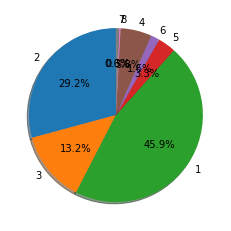

In [30]:
# See # of prefix in zero-percent sentence

zeropercent_retention_sentence_NE = [NE_extraction(i)[0] for i in zeropercent_retention_sentence]

zeropercent_len_NE = []

for dic in zeropercent_retention_sentence_NE:
  temp_num = 0
  for key,value in dic.items():
    if len(value)>0:
      zeropercent_len_NE.append(len(value))

counts = Counter(zeropercent_len_NE)
fig1, ax1 = plt.subplots()
ax1.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)

# zeropercent_retention_sentence_NE


In [30]:
Temp_data_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/qualitative/'
Temp_data_name = 'process_sentence'

with open(Temp_data_dir+Temp_data_name,'w') as f:
  # print(type(sentence))
  for sen in zeropercent_retention_sentence:
    f.write("{}\n".format(sen))
f.close()

Simplify sentence with a model 

In [31]:
MODEL_DIR = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/'

model_dir_dict = {}
add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1661558615350/',model_name='NE_recovery',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 1.0561701019588032, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.9757367588571789, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.7395441030797956, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.5234261949274427, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}
)
test_data_dir_list,test_data_list = [Temp_data_dir+Temp_data_name],['asset_valid_pred']
model_dir_dictx = model_dir_dict
model_dir_dictx[0]
comp_sentence = show_simplify(test_data_dir_list[0])
# comp_sentence[:5]
print(len(comp_sentence))

token_ori_2 = generate_output([0],test_data_dir_list,test_data_list, model_dir_dictx)
comp_sentence2, simp_sentence2 = show_simplify(test_data_dir_list[0],token_ori_2[0]+test_data_list[0])
word_retention_rate(comp_sentence2, simp_sentence2)

added: {'model_id': 0, 'exp_dir': '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/local_1661558615350/', 'model_name': 'NE_recovery', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.0561701019588032, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.9757367588571789, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.7395441030797956, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.5234261949274427, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}
1171
| model_name is NE_recovery
| exp_dir is /content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/local_1661558615350/
| output_dir /content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/
| use provided kwargs
| use preprocessors_kwargs {'LengthRatioPreprocessor': {'target_ratio': 1.0561701019588032, 'use_short_name': False}, 'Replace

/usr/local/lib/python3.7/dist-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/usr/local/lib/python3.7/dist-packages/fairseq/sequence_generator.py:651: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = idx // beam_size


created_dir ['/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/model_0_local_1661558615350/16/']
simplified:

-------------------------------------------------------------------------------- 
 complex:  <NEXT_NE> inscription <NEXT_NE> attests <SENT_START> Around the drum his name is written in Georgian.
simple: Around the drum his inscription is attests in Georgian.
-------------------------------------------------------------------------------- 
 complex:  <NEXT_NE> Jameson's <NEXT_NE> autobiography, <NEXT_NE> Cautionary <SENT_START> Jameson wrote an autobiography in 2004. The book was called How to Make Love Like a Porn Star.
simple: Jameson wrote an autobiography in 2004. The Jameson's Cautionary was called How to Make Love Like aorn Star.
-------------------------------------------------------------------------------- 
 complex:  <NEXT_NE> particularly <SENT_START> The most famous fruit there is the kiwifruit.
simple: The most famous fruit there is particularly kiwifruit.
-

0.47458351131994875

In [24]:
# print(len(simp_sentence2))

1171


In [49]:
### reconstuct the entire dataset

reconstructed_dataset = comp_sentence1_interstage.copy()
reconstructed_dataset = [NE_extraction(i)[1] for i in reconstructed_dataset]

for i,j in enumerate(simp_sentence2):
  index = sentence_no_retention_index[i]
  reconstructed_dataset[index] = j 
  # print(comp_sentence1_interstage[index])
  # print(reconstructed_dataset[index])
  # print('-'*10)


In [50]:
len(reconstructed_dataset)

2000

In [54]:
Temp_data_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/qualitative/'
Temp_data_name = 'reconstruct_dataset_asset_test'

with open(Temp_data_dir+Temp_data_name,'w') as f:
  # print(type(sentence))
  for sen in reconstructed_dataset:
    f.write("{}\n".format(sen))
f.close()

In [55]:
interstage_sentence = Temp_data_dir+Temp_data_name
ast.literal_eval(os.popen("easse evaluate -t asset_valid -m 'bleu,sari,fkgl' -q < %s" %interstage_sentence).read())

{'bleu': 64.519,
 'sari': 38.438,
 'fkgl': 7.761,
 'quality_estimation': {'Compression ratio': 0.975,
  'Sentence splits': 1.264,
  'Levenshtein similarity': 0.803,
  'Exact copies': 0.415,
  'Additions proportion': 0.206,
  'Deletions proportion': 0.226,
  'Lexical complexity score': 8.175}}

In [61]:
# reconstructed_dataset[:30]
word_retention_rate(comp_sentence1_interstage, reconstructed_dataset)

--------------------------------------------------
simple_NE retention rate 0.6165835411471322
--------------------------------------------------


0.6165835411471322

# Full pipeline function

if the using the bart_wikilarge_mined, then first simplify the original asset, and then use the prefix from spacy to add to the simplified sentence. 

2. reconstruct the sentence with 

In [11]:
def first_stage_analysis_prefix(tokenize_dataset_path,model1_dir, model2_dir,ifbaseline, original_asset = None):

  if ifbaseline == True:
    assert original_asset!= None

  if ifbaseline == False:
    MODEL_DIR = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/'
    # print(MODEL_DIR+model1_dir[0],model1_dir[1])
    model_dir_dict = {}

    def add_item_to_dict(model_dir_dict,**kwargs):

      id = len(model_dir_dict)
      model_dir_dict[id]={}

      for key, value in kwargs.items():
        model_dir_dict[id][key]=value
      print('added:',model_dir_dict[id])
      return model_dir_dict

    if model1_dir[1] == None:
      model1_dir[1] = {
            'LengthRatioPreprocessor': {'target_ratio': 0.9, 'use_short_name': False},
            'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.65, 'use_short_name': False},
            'WordRankRatioPreprocessor': {'target_ratio': 0.75, 'language': 'en', 'use_short_name': False},
            'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.4, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}
    



    model_dir_dict = add_item_to_dict(model_dir_dict,model_id=len(model_dir_dict),exp_dir = MODEL_DIR+model1_dir[0],model_name='temp_model',recommended_preprocessors_kwargs=model1_dir[1])
    test_data_dir_list,test_data_list = [tokenize_dataset_path],['temp_data_output']
    print('here1')
    token_ori_2 = generate_output([0],test_data_dir_list,test_data_list, model_dir_dict)
    comp_sentence, simp_sentence = read_lines(test_data_dir_list[0]), read_lines(token_ori_2[0]+test_data_list[0])
    stage1_simp_dir = token_ori_2[0]+test_data_list[0]

    ### Interstage process 
    
    ### Find the sentence that dont have any prefix existed
    comp_sentence1_interstage = []
    sentence_no_retention_index = [] ###
    for i, sen in enumerate(comp_sentence):
      sentence = reconstruct_simplified_data_extra_NE_simp(sen,simp_sentence[i])   
      tempNE = NE_extraction(sentence)[0]
      var = 1
      tempNE_list = []
      for key,value in tempNE.items():
        # print(value)
        for k in value:
          tempNE_list.append(k)
      # print(tempNE_list)
      if tempNE_list[0] != '':
        var = 0   ### Since the NE list is not None 
      if var == 1:

        comp_sentence1_interstage.append(sen)
      else:
        comp_sentence1_interstage.append(sentence)
        sentence_no_retention_index.append(i)

    print('First stage report- example')




    print('word retention without simplification (per sentence):')
    word_retention_rate(comp_sentence,[NE_extraction(i)[1] for i in comp_sentence])
    word_retention_rate_per_sentence(comp_sentence,[NE_extraction(i)[1] for i in comp_sentence])

    print('word retention with simplification (per sentence):')
    word_retention_rate(comp_sentence, simp_sentence)
    word_retention_rate_per_sentence(comp_sentence,simp_sentence)

    print('simplify result (ASSET valid/testing)')
    stage1_report_valid = ast.literal_eval(os.popen("easse evaluate -t asset_valid -m 'bleu,sari,fkgl' -q < %s" %stage1_simp_dir).read())
    print(stage1_report_valid)
    print('zero percent retention rate')
    zeropercent_retention_sentence = [comp_sentence1_interstage[i] for i in sentence_no_retention_index]
    print('Stage 1 report end')

    # print('Stage 2 starts')
    return 




In [10]:
asset_ne_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2/valid.complex'

firstmodel_dir = ['local_1660919962534/',None]
secondmodel_dir = 'local_1660919962534/'

first_stage_analysis_prefix(asset_ne_dir,firstmodel_dir, secondmodel_dir,False)

added: {'model_id': 0, 'exp_dir': '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/local_1660919962534/', 'model_name': 'temp_model', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.9, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.65, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.75, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.4, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}
here1
| model_name is temp_model
| exp_dir is /content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/local_1660919962534/
| output_dir /content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/
| use provided kwargs
| use preprocessors_kwargs {'LengthRatioPreprocessor': {'target_ratio': 0.9, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.65, 'use_short_name': Fal

/usr/local/lib/python3.7/dist-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/usr/local/lib/python3.7/dist-packages/fairseq/sequence_generator.py:651: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = idx // beam_size


created_dir ['/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/model_0_local_1660919962534/53/']
First stage report- example
word retention without simplification (per sentence):
--------------------------------------------------
simple_NE retention rate 1.0
--------------------------------------------------
--------------------------------------------------
Word retention rate per sentence
simple_NE retention rate 1.0
difficult_NE retention rate nan
total_NE retention rate 1.0
--------------------------------------------------
word retention with simplification (per sentence):
--------------------------------------------------
simple_NE retention rate 0.8737610850286907
--------------------------------------------------
--------------------------------------------------
Word retention rate per sentence
simple_NE retention rate 0.8951381701363087
difficult_NE retention rate nan
total_NE retention rate 0.8951381701363087
--------------------------------------------------
simplif

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'bleu': 44.89, 'sari': 36.613, 'fkgl': 7.598, 'quality_estimation': {'Compression ratio': 1.417, 'Sentence splits': 1.736, 'Levenshtein similarity': 0.682, 'Exact copies': 0.002, 'Additions proportion': 0.439, 'Deletions proportion': 0.16, 'Lexical complexity score': 8.04}}
zero percent retention rate
Stage 1 report end
Stage 2 starts


In [32]:
torch.cuda.empty_cache()